In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d sondosaabed/casia-iris-thousand

Dataset URL: https://www.kaggle.com/datasets/sondosaabed/casia-iris-thousand
License(s): MIT
100% 491M/491M [00:01<00:00, 262MB/s]
100% 491M/491M [00:01<00:00, 282MB/s]


In [4]:
import zipfile

zipref = zipfile.ZipFile('/content/casia-iris-thousand.zip', 'r')
zipref.extractall('/content')
zipref.close()

In [ ]:
import os
sub_list = []
results = []

for pathdir, pathname, filename in os.walk('/content/CASIA-Iris-Thousand'):
  if len(filename)>0:
    sub_dir = os.path.dirname(pathdir).split('/')[4]
    results.append((sub_dir, os.path.basename(pathdir), len(filename)))

results.sort()

for sub_dir, base_name, files in results:
  if sub_dir in sub_list:
    print(f'There are {files} files in {base_name} of subject "{sub_dir}"')
    print('\n')
  else:
    print(f'There are {files} files in {base_name} of subject "{sub_dir}"')
    sub_list.append(sub_dir)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import random

def plot_image(subject, image_name):
  subject_int = int(subject)
  subject_entry = next((entry for entry in results if entry[0] == subject), None)
  if not subject_entry:
    print(f"No data found for subject {subject_int}.")
    return
  sub_dir, base_name, files = subject_entry
  random_file = random.randint(0, files-1)
  filepath_L = os.path.join('/content/CASIA-Iris-Thousand/CASIA-Iris-Thousand', sub_dir, 'L')
  filepath_R = os.path.join('/content/CASIA-Iris-Thousand/CASIA-Iris-Thousand', sub_dir, 'R')
  files_L = os.listdir(filepath_L)
  files_R = os.listdir(filepath_R)
  img_L = plt.imread(os.path.join(filepath_L, files_L[random_file]))
  img_R = plt.imread(os.path.join(filepath_R, files_R[random_file]))
  if image_name == 'A' and subject_entry:
    fig, ax = plt.subplots(1,2, facecolor = 'black', figsize = (10, 5))
    fig.subplots_adjust(top = 0.8)
    title_text = f'SUBJECT - {subject_int}'
    fig.suptitle(title_text, color = 'white', y = 0.85, fontsize = 20)
    fig.text(0.5, 0.79, '-' * (len(title_text)+7), color='white', fontsize=20, ha='center', va='center')
    ax[0].imshow(img_L, cmap = 'gray')
    ax[0].axis('off')
    ax[0].annotate('Left', xy = (0.5, -0.13), xycoords = 'axes fraction', ha = 'center', color = 'white', fontsize = 15)
    ax[1].imshow(img_R, cmap = 'gray')
    ax[1].axis('off')
    ax[1].annotate('Right', xy = (0.5, -0.13), xycoords = 'axes fraction', ha = 'center', color = 'white', fontsize = 15)
    plt.show()

  elif image_name == 'L':
    plt.figure(figsize = (10, 5), facecolor = 'black')
    title_text = f'SUBJECT - {subject_int}'
    plt.title(title_text, color = 'white', y = 1.05, fontsize = 20)
    plt.text(0.5, 1.05, '-' * (len(title_text)+7), color='white', fontsize=20, va = 'center', ha = 'center', transform = plt.gca().transAxes)
    plt.axis('off')
    plt.imshow(img_L, cmap = 'gray')
    plt.facecolor = 'black'
    plt.annotate('Left', xy=(0.5, -0.08), xycoords='axes fraction', ha='center', va='center', color='white', fontsize=15)
    plt.show()

  elif image_name == 'R':
    plt.figure(figsize = (10, 5), facecolor = 'black')
    title_text = f'SUBJECT - {subject_int}'
    plt.title(title_text, color = 'white', y = 1.05, fontsize = 20)
    plt.text(0.5, 1.05, '-' * (len(title_text)+7), color='white', fontsize=20, va = 'center', ha = 'center', transform = plt.gca().transAxes)
    plt.axis('off')
    plt.imshow(img_R, cmap = 'gray')
    plt.facecolor = 'black'
    plt.annotate('Right', xy=(0.5, -0.08), xycoords='axes fraction', ha='center', va='center', color='white', fontsize=15)
    plt.show()


In [7]:
plot_image('0', 'A')

No data found for subject 0.


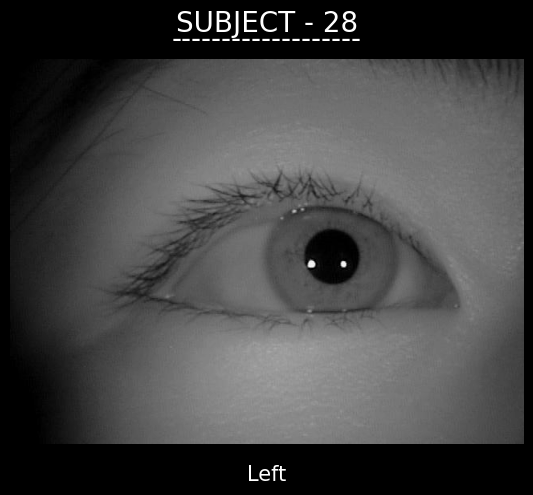

In [8]:
plot_image('028', 'L')

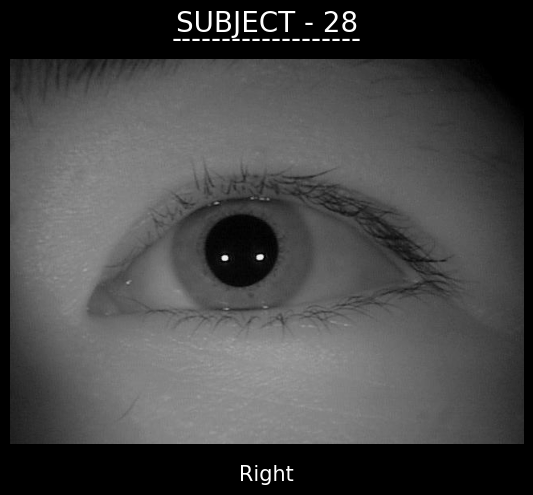

In [9]:
plot_image('028', 'R')

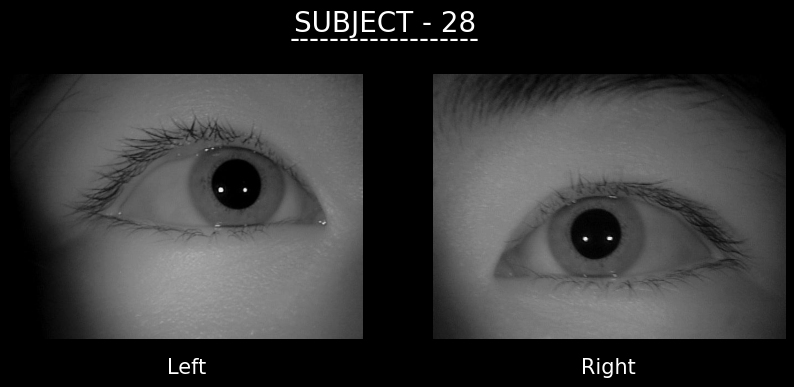

In [10]:
plot_image('028', 'A')

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence, to_categorical

# Define the data augmentation configuration for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.3
)

dataset_path = '/content/CASIA-Iris-Thousand/CASIA-Iris-Thousand'  # Replace with the actual path to your dataset
total_classes = os.listdir(dataset_path)
total_classes.sort()
selected_classes = total_classes[:100]

In [20]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, concatenate
from tensorflow.keras.models import Model
from keras.optimizers import Adam

def create_combined_model(num_subjects, num_eye_types, input_shape=(224, 224, 3)):

    input_images = Input(shape=input_shape, name = 'input_images')

    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_images)

    # Unfreeze the last few layers of the base model for fine-tuning
    for layer in base_model.layers:
        layer.trainable = False

    # Get the output of the base model
    base_model_output = base_model.output

    ### Model 1: Eye Type Identification ###
    x1 = Conv2D(32, (3, 3), activation='relu')(base_model_output)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Conv2D(32, (2, 2), activation='relu')(x1)
    x1 = MaxPooling2D((1, 1))(x1)
    x1 = Flatten()(x1)
    x1 = Dense(64, activation='relu')(x1)
    eye_output = Dense(num_eye_types, activation='softmax', name='eye_output')(x1)

    ### Model 2: Subject Identification ###
    x2 = Conv2D(128, (3, 3), activation='relu')(base_model_output)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Conv2D(64, (2, 2), activation='relu')(x2)
    x2 = Conv2D(32, (1, 1), activation='relu')(x2)
    x2 = MaxPooling2D((1, 1))(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    x2 = Dense(100, activation='relu')(x2)
    x2 = Dense(100, activation='relu')(x2)
    x2 = Dense(100, activation='relu')(x2)
    subject_output = Dense(num_subjects, activation='softmax', name='subject_output')(x2)

    ### Define the combined model ###
    combined_model = Model(inputs=input_images, outputs=[eye_output, subject_output])

    # Compile the model with appropriate loss functions and metrics
    combined_model.compile(optimizer=Adam(),
                           loss={'eye_output': 'categorical_crossentropy', 'subject_output': 'categorical_crossentropy'},
                           metrics={'eye_output': 'accuracy', 'subject_output': 'accuracy'})

    return combined_model

# Create the model
combined_model = create_combined_model(100, 2)

# Print model summary
combined_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_images (InputLayer)   [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_6 (Rescaling)     (None, 224, 224, 3)          0         ['input_images[0][0]']        
                                                                                                  
 normalization_3 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_6[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_7 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_3[0][0]'

In [21]:
class CustomDataGenerator(Sequence):
    def __init__(self, dataset_path, target_size=(224, 224), batch_size=32, subset='training', validation_split=0.3):
        self.dataset_path = dataset_path
        self.target_size = target_size
        self.batch_size = batch_size
        self.subset = subset
        self.validation_split = validation_split
        self.subjects = selected_classes  # Use selected classes
        self.num_subjects = len(self.subjects)
        self.eye_types = ['L', 'R']
        self.num_eye_types = len(self.eye_types)
        self.images_path = []
        self.labels = []
        self.load_data()
        self.on_epoch_end()
        self.datagen = train_datagen

    def load_data(self):
        for subject in self.subjects:
            subject_path = os.path.join(self.dataset_path, subject)
            for eye_type in self.eye_types:
                eye_path = os.path.join(subject_path, eye_type)
                if not os.path.exists(eye_path):
                    continue
                image_names = os.listdir(eye_path)
                if self.subset == 'training':
                    split_idx = int(len(image_names) * (1 - self.validation_split))
                    image_names = image_names[:split_idx]
                else:
                    split_idx = int(len(image_names) * (1 - self.validation_split))
                    image_names = image_names[split_idx:]
                for image_name in image_names:
                    image_path = os.path.join(eye_path, image_name)
                    self.images_path.append(image_path)
                    self.labels.append((self.subjects.index(subject), self.eye_types.index(eye_type)))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.images_path))
        np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.images_path) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images_path = [self.images_path[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]

        batch_images = []
        valid_indexes = []
        for i, image_path in enumerate(batch_images_path):
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, self.target_size)
                image = self.datagen.random_transform(image)  # Apply data augmentation
                batch_images.append(image)
                valid_indexes.append(i)

        batch_images = np.array(batch_images)
        batch_labels = [batch_labels[i] for i in valid_indexes]

        batch_subject_labels = [label[0] for label in batch_labels]
        batch_eye_labels = [label[1] for label in batch_labels]

        batch_subject_labels = to_categorical(batch_subject_labels, num_classes=self.num_subjects)
        batch_eye_labels = to_categorical(batch_eye_labels, num_classes=self.num_eye_types)

        return {'input_images': batch_images}, {'subject_output': batch_subject_labels, 'eye_output': batch_eye_labels}

In [ ]:
# Create training and validation generators
train_data = CustomDataGenerator(
    dataset_path=dataset_path,
    target_size=(224, 224),
    batch_size=32,
    subset='training'
)

valid_data = CustomDataGenerator(
    dataset_path=dataset_path,
    target_size=(224, 224),
    batch_size=32,
    subset='validation'
)

In [33]:
# Fit the model
history = combined_model.fit(
    train_data,
    validation_data=valid_data,
    epochs=10,
    verbose=1
)

Epoch 1/10
43/43 [==============================] - 27s 636ms/step - loss: 0.3297 - eye_output_loss: 0.0604 - subject_output_loss: 0.2694 - eye_output_accuracy: 0.9760 - subject_output_accuracy: 0.9068 - val_loss: 0.7536 - val_eye_output_loss: 0.0969 - val_subject_output_loss: 0.6568 - val_eye_output_accuracy: 0.9653 - val_subject_output_accuracy: 0.8281
Epoch 2/10
43/43 [==============================] - 30s 696ms/step - loss: 0.3844 - eye_output_loss: 0.0545 - subject_output_loss: 0.3299 - eye_output_accuracy: 0.9811 - subject_output_accuracy: 0.8988 - val_loss: 0.6563 - val_eye_output_loss: 0.1241 - val_subject_output_loss: 0.5322 - val_eye_output_accuracy: 0.9566 - val_subject_output_accuracy: 0.8750
Epoch 3/10
43/43 [==============================] - 26s 615ms/step - loss: 0.3148 - eye_output_loss: 0.0501 - subject_output_loss: 0.2647 - eye_output_accuracy: 0.9825 - subject_output_accuracy: 0.9199 - val_loss: 0.4654 - val_eye_output_loss: 0.1225 - val_subject_output_loss: 0.3430 -

In [32]:
combined_model.save('combined_model.keras')

In [ ]:
from google.colab import files
files.upload()

In [36]:
from keras.models import load_model
combined_model = load_model('combined_model.keras')

In [42]:
#@title Predicting images

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# Define the data augmentation configuration for validation
valid_datagen = ImageDataGenerator(rescale=1./255)

total_classes = os.listdir('/content/CASIA-Iris-Thousand/CASIA-Iris-Thousand')
total_classes.sort()
selected_classes = total_classes[:100]

# Load the validation dataset
test_data = CustomDataGenerator(
    dataset_path='/content/CASIA-Iris-Thousand/CASIA-Iris-Thousand',
    target_size=(224, 224),
    batch_size=32,
    subset='validation'
)

In [46]:
batch_images, batch_labels = next(iter(test_data))
print(batch_images['input_images'].shape)
print(batch_labels['subject_output'].shape)
print(batch_labels['eye_output'].shape)

(32, 224, 224, 3)
(32, 100)
(32, 2)


In [57]:
#@title Plot Function
import matplotlib.pyplot as plt
import numpy as np
import cv2

def plot_images_with_predictions(data_generator, model, num_images=9):

    # Fetch a batch of images and labels
    batch_images, batch_labels = next(iter(test_data))

    # Check data shapes
    print(f"Images shape: {batch_images['input_images'].shape}")
    print(f"True labels shape: {len(batch_labels)}")
    print(f"True eye labels shape: {batch_labels['eye_output'].shape}")
    print(f"True subject labels shape: {batch_labels['subject_output'].shape}")

    # Determine the number of images to plot (should be a perfect square)
    num_images = min(num_images, batch_images['input_images'].shape[0])
    sqrt_num_images = int(np.sqrt(num_images))

    # Use the model to predict labels
    predictions = model.predict(batch_images['input_images'])

    # Separate the predictions for eye type and subject
    predicted_eye_types = predictions[0]
    predicted_subjects = predictions[1]

    # Plot the images
    plt.figure(figsize=(15, 15), facecolor = 'black')
    for i in range(num_images):
        plt.subplot(sqrt_num_images, sqrt_num_images, i + 1)
        plt.imshow(batch_images['input_images'][i])
        plt.axis('off')

        # Determine true and predicted labels
        true_eye_type = np.argmax(batch_labels['eye_output'][i])
        true_subject = np.argmax(batch_labels['subject_output'][i])
        predicted_eye_type = np.argmax(predicted_eye_types[i])
        predicted_subject = np.argmax(predicted_subjects[i])

        # Display the results
        true_label_str = f'True: Eye-{true_eye_type}, Sub-{true_subject}'
        predicted_label_str = f'Pred: Eye-{predicted_eye_type}, Sub-{predicted_subject}'
        if true_eye_type == predicted_eye_type:
            plt.title(f'{true_label_str}\n{predicted_label_str}', fontsize=8, color = 'green')
        else:
            plt.title(f'{true_label_str}\n{predicted_label_str}', fontsize=8, color = 'red')

    plt.tight_layout()
    plt.show()


Images shape: (32, 224, 224, 3)
True labels shape: 2
True eye labels shape: (32, 2)
True subject labels shape: (32, 100)
1/1 [==============================] - 0s 27ms/step


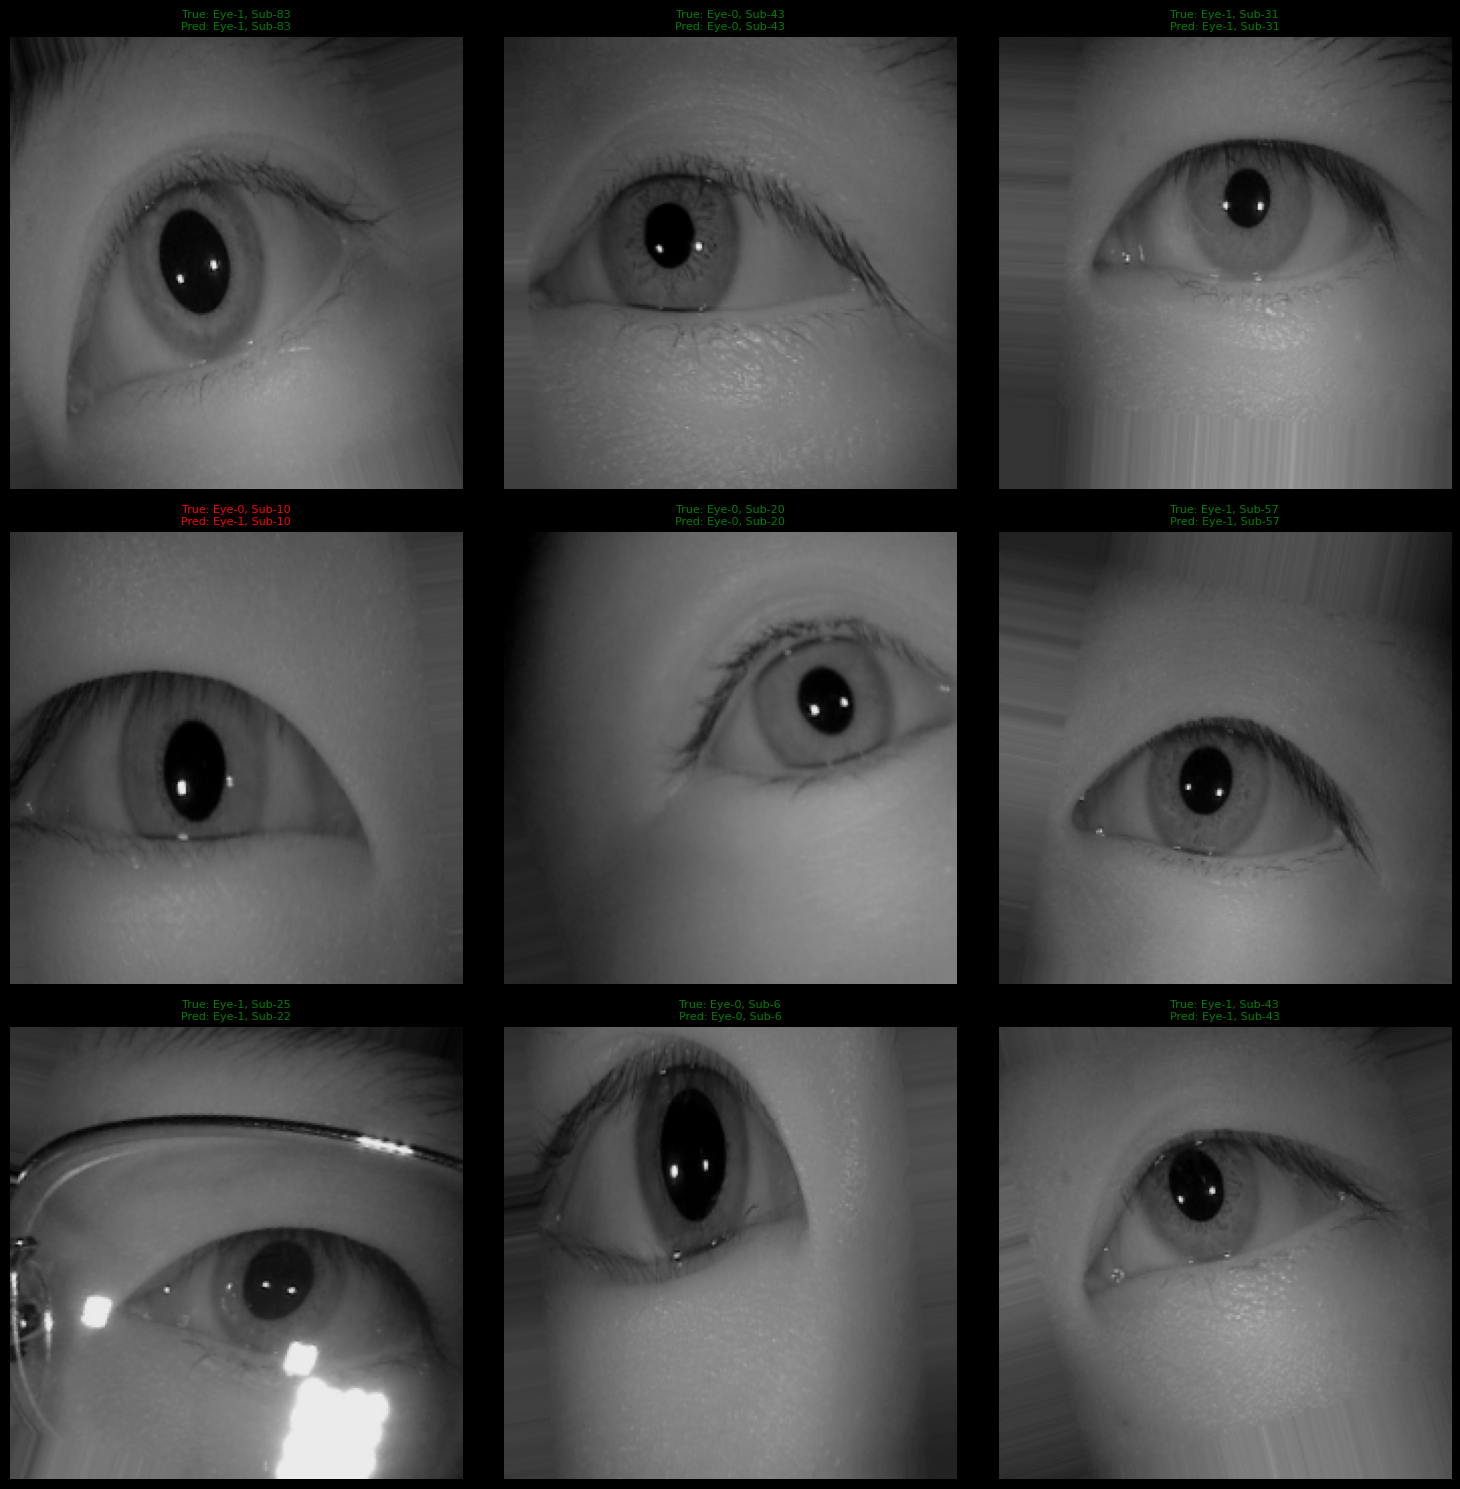

In [58]:
plot_images_with_predictions(test_data, combined_model)

The model works well!